Link to the dataset: https://www.kaggle.com/datasets/mfaaris/spotify-app-reviews-2022

In this notebook, we will try and attempt to use deep learning architectures to classify sentiment of the Spotify-app reviews.

In [ ]:
# Required to download a kaggle dataset
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# Downloading dataset
! kaggle datasets download mfaaris/spotify-app-reviews-2022
! unzip spotify-app-reviews-2022.zip

In [59]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import copy
import random
from collections import Counter


import nltk
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.utils import to_categorical

In [60]:
pd.set_option('display.max_colwidth', None)
spotify_reviews_df = pd.read_csv("reviews.csv")
spotify_reviews_df.head()

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality and the app is easy to use. Also very quick and friendly support.",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This app is super great. I give it five stars+,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience on Android 12"" is too annoying. Please let's get rid of this.",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't put on my playlist??? And why do we have shuffle play?,1,1,NaN


In [61]:
# Deleting unnecessary columns
del spotify_reviews_df["Time_submitted"]
del spotify_reviews_df["Reply"]

In [62]:
spotify_reviews_df.isnull().sum()

Review            0
Rating            0
Total_thumbsup    0
dtype: int64

In [63]:
# Total amount of reviews
len(spotify_reviews_df.index)

61594

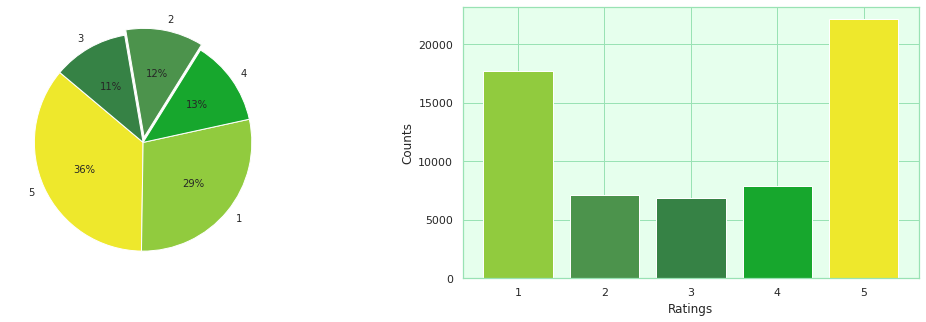

In [64]:
# Visualising the spread of the data
custom_colors = ['#eee82c', '#91cb3e', '#17A72D', '#4c934c', '#368245']
sns.set(rc={"grid.color":"#99e2b4", "axes.edgecolor":"#99e2b4", 
            "axes.facecolor":"#e6ffed"})

ratings_counts = spotify_reviews_df["Rating"].value_counts().to_dict()

labels, counts = zip(*ratings_counts.items())

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.pie(counts, labels = labels, textprops={'fontsize': 10}, startangle=140, 
       autopct='%1.0f%%', colors=custom_colors, explode=[0,0,0,0.05,0])

plt.subplot(1, 2, 2)
plt.bar(labels, counts, color=custom_colors)
plt.xlabel("Ratings")
plt.ylabel("Counts")

plt.show()

In [65]:
# Preprocessing

# Converting to lowercase
spotify_reviews_df["Review"] = spotify_reviews_df["Review"].apply(lambda x: x.lower())

# Removing urls
def remove_url(text):
  re_url = re.compile("https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)")
  return re_url.sub('', text)

spotify_reviews_df["Review"] = spotify_reviews_df["Review"].apply(remove_url)

# Removing punctuation
def remove_punc(text):
  return text.translate(str.maketrans("", "", string.punctuation))

spotify_reviews_df["Review"] = spotify_reviews_df["Review"].apply(remove_punc)

Text(0.5, 1.0, 'Word count distribution for each rating')

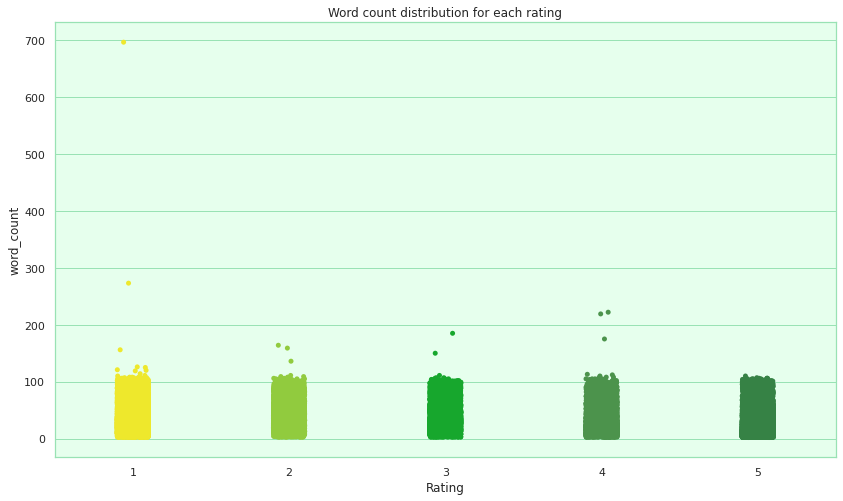

In [66]:
# Avg. length of a review (in terms of words) for each rating
def count_words(text):
   return len([word for word in text.split()])

spotify_reviews_df["word_count"] = spotify_reviews_df["Review"].apply(count_words)

sns.set(rc={"grid.color":"#99e2b4", "axes.facecolor":"#e6ffed",
            "axes.edgecolor":"#99e2b4"})
plt.figure(figsize=(14, 8))
ax = sns.stripplot(data=spotify_reviews_df, x='Rating', y='word_count', alpha=1, palette=custom_colors, edgecolor=custom_colors)
ax.set_title('Word count distribution for each rating')

Text(0.5, 1.0, 'Avg. amount of words per rating')

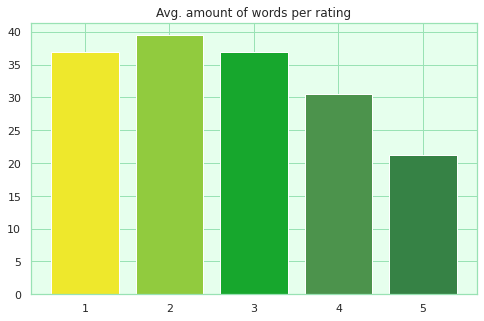

In [67]:
text_length_means = spotify_reviews_df.groupby(by="Rating")["word_count"].mean().to_dict()

# Converting keys to type <str> to make them categorical
text_length_means = {str(key):value for key, value in text_length_means.items()}

plt.figure(figsize=(8, 5))
plt.bar(*zip(*text_length_means.items()), color=custom_colors)
plt.title("Avg. amount of words per rating")

In [68]:
# Longest review
spotify_reviews_df.word_count.max()

696

In [69]:
# Shortest review
spotify_reviews_df.word_count.min()

2

WordCloud for rating: 1


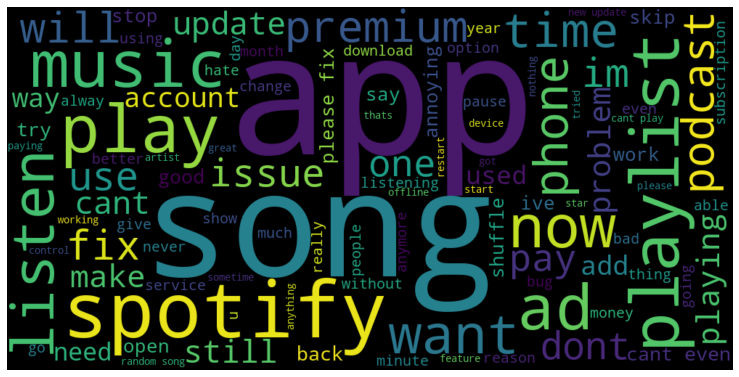


WordCloud for rating: 2


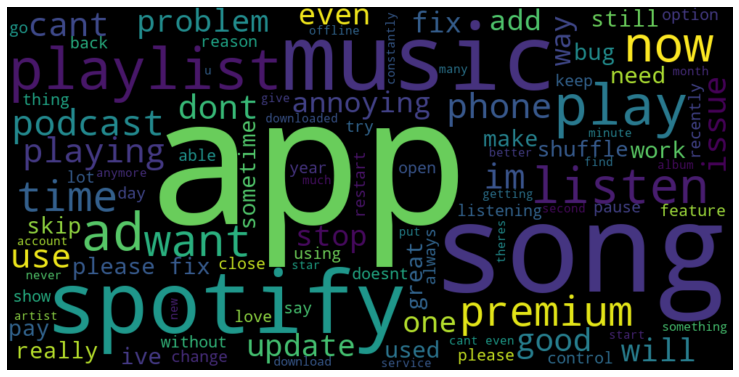


WordCloud for rating: 3


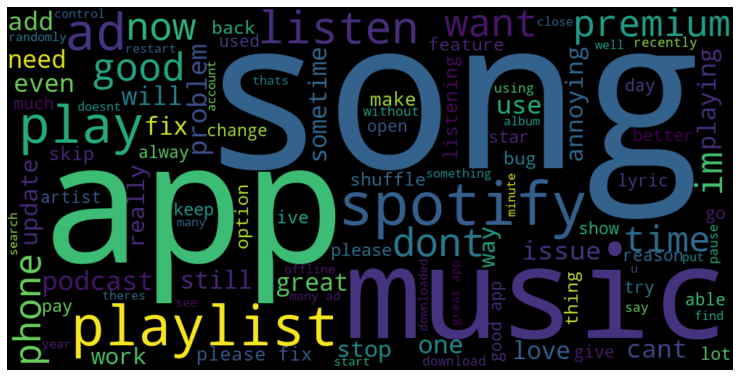


WordCloud for rating: 4


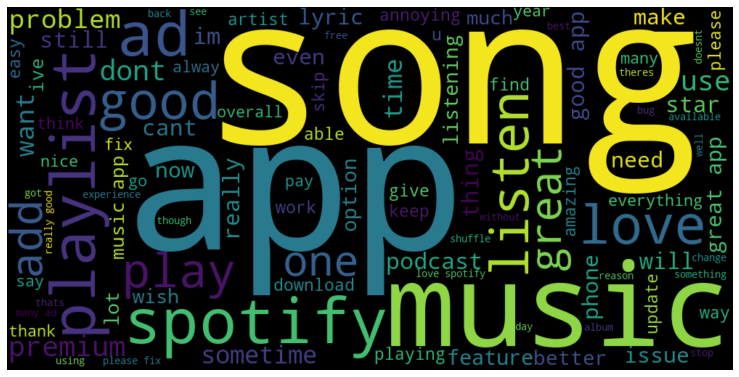


WordCloud for rating: 5


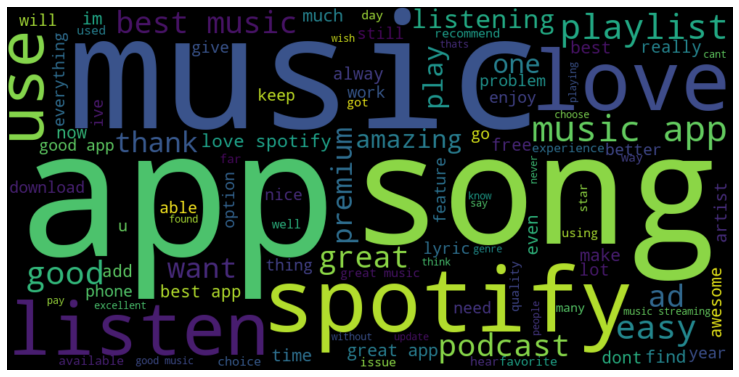

In [46]:
# Visualizing WordCloud
from wordcloud import WordCloud

def visualize_word_cloud(rating):
  text = " ".join(spotify_reviews_df[spotify_reviews_df['Rating'] == rating]["Review"])
  plt.figure(figsize = (13, 10))
  wordcloud = WordCloud(max_words=100, height=500, width=1000, 
                        background_color="black", 
                        colormap="viridis").generate(text)
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.show()

# Reviews are from 1-5
for i in range(1, 6):
  print(f"WordCloud for rating: {i}")
  visualize_word_cloud(i)
  print()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


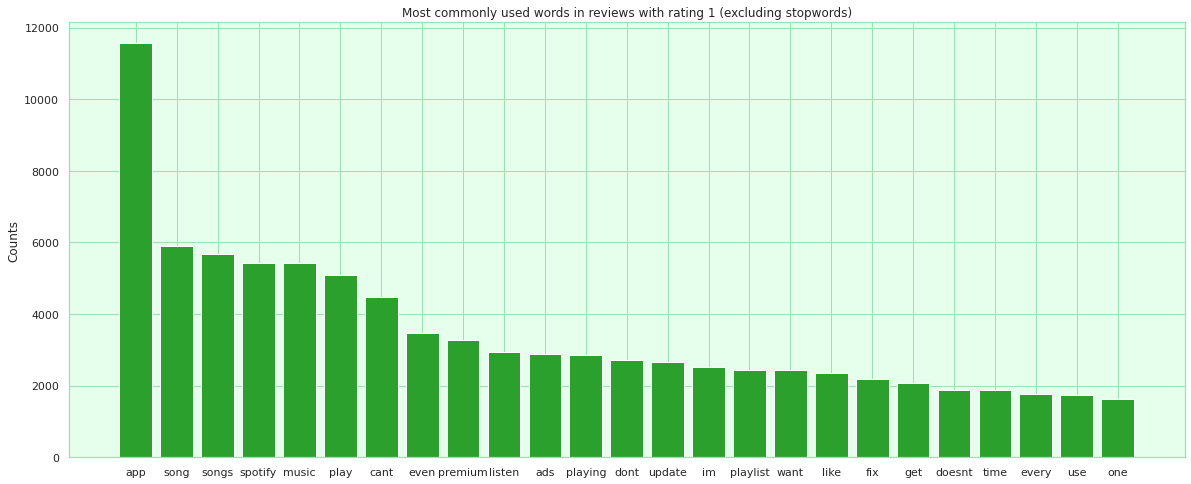

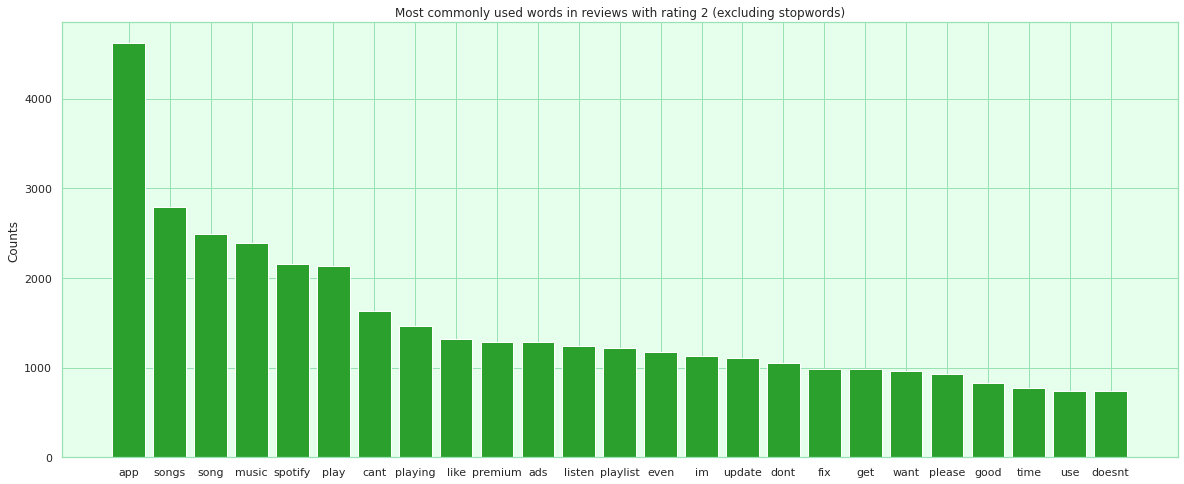

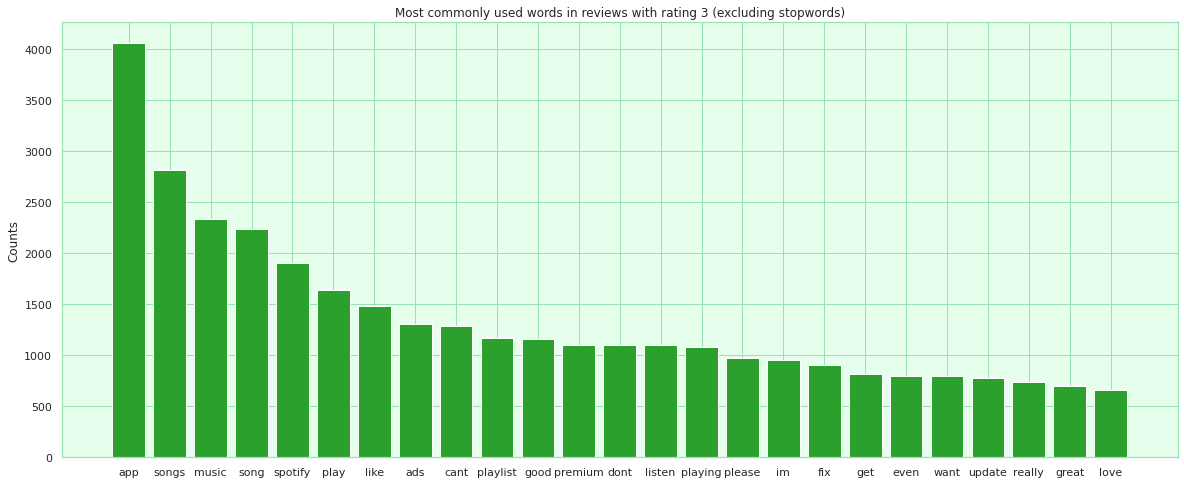

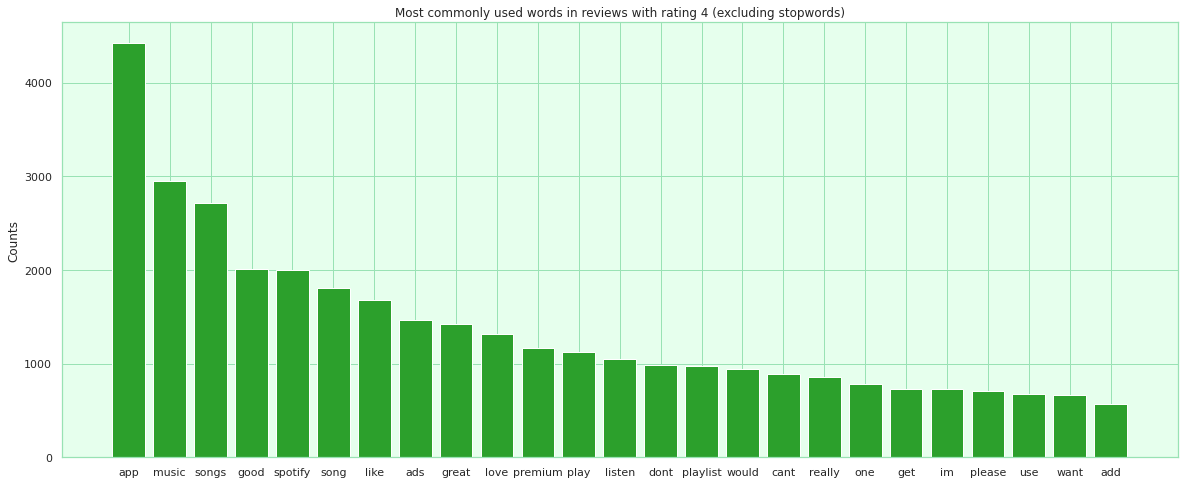

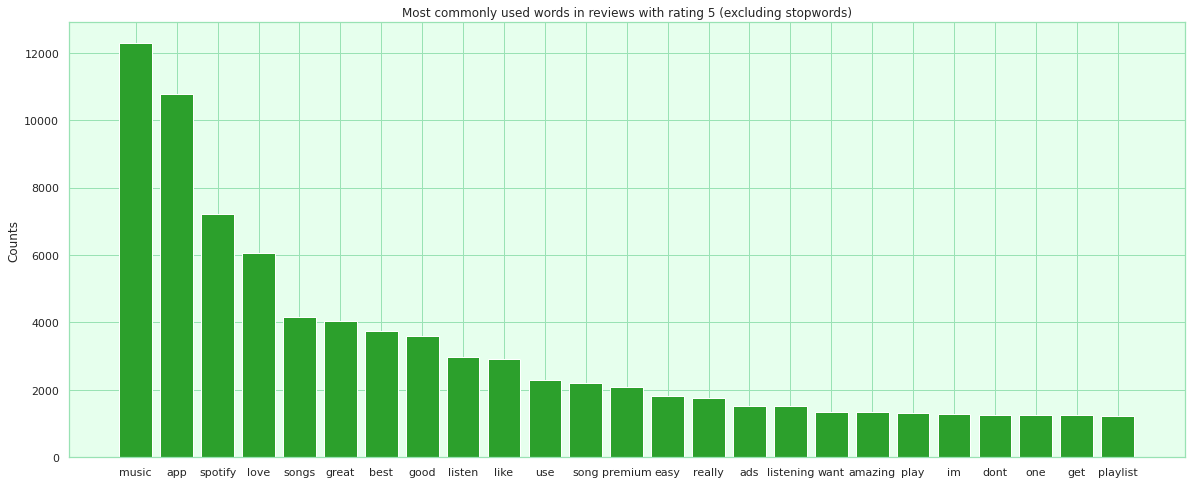

In [70]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def word_distribution_bar_plot(rating):
  all_words = []

  for sentence in spotify_reviews_df[spotify_reviews_df['Rating'] == rating]['Review'].to_list():
    for word in sentence.split():
      if word not in stop_words:
        all_words.append(word)
  
  counts = Counter(all_words).most_common(25)
  plt.figure(figsize=(20,8))
  plt.bar(*zip(*counts), color='tab:green')
  plt.title(f"Most commonly used words in reviews with rating {rating} (excluding stopwords)")
  plt.ylabel("Counts")
  plt.show()
  print()

for i in range(1, 6):
  word_distribution_bar_plot(i)

In [71]:
# Review with the most thumbs up
max_thumb = spotify_reviews_df['Total_thumbsup'].max()
print(spotify_reviews_df[spotify_reviews_df['Total_thumbsup'] == max_thumb].iloc[0]['Review'])

the app is very good i got to explore many new songs however i took out a star because of a few reasons first it sometimes lags and wont show the music dialog box on your screen or in the app and for this i have to restart it second i cannot delete my history on phone third i cannot shuffle playlists or albums they have to play on the fixed sequence fourth i cannot see which song is going to play next if its a radio and fifth sometimes the song stops and doesnt start radio


Text(8, -0.2, 'Mean: 7.65')

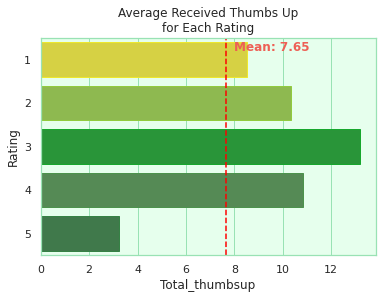

In [72]:
mean_thumb = spotify_reviews_df['Total_thumbsup'].mean()

ax = sns.barplot(data=spotify_reviews_df, y='Rating', x='Total_thumbsup', orient='h', 
                 ci=None, palette=custom_colors, edgecolor=custom_colors)
ax.set_title('Average Received Thumbs Up\nfor Each Rating')
plt.axvline(mean_thumb, color='red', ls='--')
plt.text(x=8, y=-0.2, s='Mean: ' + str(round(mean_thumb, 2)), color='#ee6055', weight='bold')

In [73]:
# Modelling part
texts =  spotify_reviews_df["Review"].tolist()
labels = spotify_reviews_df["Rating"].tolist()

In [74]:
# In order for labels to be turned into categorical, 1 should be subtracted from each label
labels = [label - 1 for label in labels]

In [75]:
random.seed(7)

pairs = list(zip(texts, labels))
random.shuffle(pairs)
texts, labels = zip(*pairs)
texts, labels = list(texts), list(labels)

In [76]:
# Random baseline classifier
labels_copy = copy.copy(labels)
np.random.shuffle(labels_copy)
hits_array = np.array(labels) == np.array(labels_copy)
print(f"Accuracy of a random baseline classifier: {hits_array.mean()}")

Accuracy of a random baseline classifier: 0.2518264766048641


In [77]:
# Splitting data following 80/10/10 split
num_val_samples = int(0.10 * len(texts))
num_train_samples = len(texts) - 2 * num_val_samples

train_inputs =  texts[:num_train_samples]
train_targets = labels[:num_train_samples]

val_inputs = texts[num_train_samples:num_train_samples + num_val_samples]
val_targets = labels[num_train_samples:num_train_samples + num_val_samples]

test_inputs = texts[num_train_samples + num_val_samples:]
test_targets = labels[num_train_samples + num_val_samples:]

In [78]:
print(f"Train samples: {len(train_inputs)}")
print(f"Validation samples: {len(val_inputs)}")
print(f"Test samples: {len(test_inputs)}")

Train samples: 49276
Validation samples: 6159
Test samples: 6159


In [79]:
# Creating batched datasets, each batch of size 32
batch_size = 32

def make_dataset(inputs, targets):
  targets = to_categorical(targets, num_classes=5)  # one-hot encoding
  dataset = tf.data.Dataset.from_tensor_slices((inputs, targets))
  dataset = dataset.batch(batch_size)

  return dataset

train_ds = make_dataset(train_inputs, train_targets)
val_ds = make_dataset(val_inputs, val_targets)
test_ds = make_dataset(test_inputs, test_targets)

In [80]:
for inputs, targets in train_ds:
  print("inputs.shape:", inputs.shape)
  print("inputs.dtype:", inputs.dtype)
  print("targets.shape:", targets.shape)
  print("inputs[0]:", inputs[0])
  print("targets[0]:", targets[0])
  break

inputs.shape: (32,)
inputs.dtype: <dtype: 'string'>
targets.shape: (32, 5)
inputs[0]: tf.Tensor(b'i luv this app amazing performance i gave 4 stars cuz the ads are a little annoying', shape=(), dtype=string)
targets[0]: tf.Tensor([0. 0. 0. 1. 0.], shape=(5,), dtype=float32)


In [81]:
# Utility function to vectorize datasets
def vectorize_datasets(max_tokens, output_mode, ngrams=None, output_sequence_length=None):
  text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode=output_mode,
    ngrams=ngrams,
    standardize=None,
    output_sequence_length=output_sequence_length)
  
  samples_ds = train_ds.map(lambda x, y: x)
  text_vectorization.adapt(samples_ds)

  vectorized_train = train_ds.map(               
    lambda x, y: (text_vectorization(x), y),        
    num_parallel_calls=4)
  
  vectorized_val = val_ds.map(                   
    lambda x, y: (text_vectorization(x), y),        
    num_parallel_calls=4)     
                        
  vectorized_test = test_ds.map(                 
      lambda x, y: (text_vectorization(x), y),        
      num_parallel_calls=4)
  
  return text_vectorization, vectorized_train, vectorized_val, vectorized_test

In [82]:
# First model: dense model, where each reviews
# is a multi_hot vector of unigrams and bigrams
max_tokens = 20000
_, train, val, test = vectorize_datasets(max_tokens, "multi_hot", 2)

In [83]:
for inputs, targets in train:
  print("inputs.shape:", inputs.shape)
  print("inputs.dtype:", inputs.dtype)
  print("targets.shape:", targets.shape)
  print("targets.dtype:", targets.dtype)
  print("inputs[0]:", inputs[0])
  print("targets[0]:", targets[0])
  break

inputs.shape: (32, 20000)
inputs.dtype: <dtype: 'float32'>
targets.shape: (32, 5)
targets.dtype: <dtype: 'float32'>
inputs[0]: tf.Tensor([1. 1. 1. ... 0. 0. 0.], shape=(20000,), dtype=float32)
targets[0]: tf.Tensor([0. 0. 0. 1. 0.], shape=(5,), dtype=float32)


In [84]:
# Utility function to recreate dense models
def initiate_model(max_tokens=max_tokens, output_units=5, hidden_units=16, summary=True):
  inputs = layers.Input(shape=(max_tokens,))
  x = layers.Dense(hidden_units, activation="relu")(inputs)
  x = layers.Dropout(0.25)(x)
  outputs = layers.Dense(output_units, activation="softmax")(x)
  model = keras.Model(inputs, outputs)
  model.compile(optimizer="rmsprop",
                loss="categorical_crossentropy",
                metrics=["accuracy"])
  if summary:
    model.summary()
  return model

In [85]:
dense_model = initiate_model()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_2 (Dense)             (None, 16)                320016    
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 5)                 85        
                                                                 
Total params: 320,101
Trainable params: 320,101
Non-trainable params: 0
_________________________________________________________________


In [86]:
# Utility function to plot train. vs validation losses
def plot_val_train_losses(history):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  epochs = range(1, len(loss) + 1)
  plt.plot(epochs, loss, "bo", label="Training loss")
  plt.plot(epochs, val_loss, "b", label="Validation loss")
  plt.title("Training and validation loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

In [87]:
# Utility function to train, test models, and visualize loss
def fit_test_plot(model, model_name, epochs, train, val, test):
  callbacks = [keras.callbacks.ModelCheckpoint(model_name + ".keras", save_best_only=True)]
  history = model.fit(train, validation_data=val, epochs=epochs,
                      callbacks=callbacks)
  print()
  print(f"Test acc: {model.evaluate(test)[1]:.3f}")
  print()
  plot_val_train_losses(history)

Epoch 1/10
1540/1540 [==============================] - 11s 7ms/step - loss: 1.0843 - accuracy: 0.6025 - val_loss: 0.9690 - val_accuracy: 0.6293
Epoch 2/10
1540/1540 [==============================] - 10s 7ms/step - loss: 0.9495 - accuracy: 0.6481 - val_loss: 0.9738 - val_accuracy: 0.6347
Epoch 3/10
1540/1540 [==============================] - 10s 7ms/step - loss: 0.9179 - accuracy: 0.6632 - val_loss: 0.9852 - val_accuracy: 0.6352
Epoch 4/10
1540/1540 [==============================] - 10s 7ms/step - loss: 0.8915 - accuracy: 0.6757 - val_loss: 1.0028 - val_accuracy: 0.6282
Epoch 5/10
1540/1540 [==============================] - 11s 7ms/step - loss: 0.8744 - accuracy: 0.6847 - val_loss: 1.0197 - val_accuracy: 0.6259
Epoch 6/10
1540/1540 [==============================] - 11s 7ms/step - loss: 0.8600 - accuracy: 0.6926 - val_loss: 1.0309 - val_accuracy: 0.6241
Epoch 7/10
1540/1540 [==============================] - 10s 7ms/step - loss: 0.8494 - accuracy: 0.6961 - val_loss: 1.0428 - val_ac

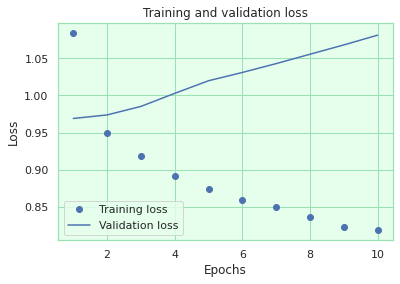

In [88]:
fit_test_plot(dense_model, "dense_one_hot", 10, train, val, test)

In [89]:
# Second model: dense model, based tf-idf vectors of unigrams and bigrams
_, train, val, test = vectorize_datasets(max_tokens, "tf_idf", 2)

In [90]:
for inputs, targets in train:
  print("inputs.shape:", inputs.shape)
  print("inputs.dtype:", inputs.dtype)
  print("targets.shape:", targets.shape)
  print("targets.dtype:", targets.dtype)
  print("inputs[0]:", inputs[0])
  print("targets[0]:", targets[0])
  break

inputs.shape: (32, 20000)
inputs.dtype: <dtype: 'float32'>
targets.shape: (32, 5)
targets.dtype: <dtype: 'float32'>
inputs[0]: tf.Tensor([43.57175    1.0042846  2.0960367 ...  0.         0.         0.       ], shape=(20000,), dtype=float32)
targets[0]: tf.Tensor([0. 0. 0. 1. 0.], shape=(5,), dtype=float32)


Epoch 1/10
1540/1540 [==============================] - 16s 10ms/step - loss: 1.1028 - accuracy: 0.5987 - val_loss: 1.0182 - val_accuracy: 0.6201
Epoch 2/10
1540/1540 [==============================] - 11s 7ms/step - loss: 0.9751 - accuracy: 0.6358 - val_loss: 1.0113 - val_accuracy: 0.6270
Epoch 3/10
1540/1540 [==============================] - 11s 7ms/step - loss: 0.9217 - accuracy: 0.6581 - val_loss: 1.0213 - val_accuracy: 0.6256
Epoch 4/10
1540/1540 [==============================] - 12s 8ms/step - loss: 0.8894 - accuracy: 0.6723 - val_loss: 1.0391 - val_accuracy: 0.6256
Epoch 5/10
1540/1540 [==============================] - 12s 8ms/step - loss: 0.8645 - accuracy: 0.6858 - val_loss: 1.0567 - val_accuracy: 0.6176
Epoch 6/10
1540/1540 [==============================] - 12s 8ms/step - loss: 0.8423 - accuracy: 0.6946 - val_loss: 1.0854 - val_accuracy: 0.6147
Epoch 7/10
1540/1540 [==============================] - 11s 7ms/step - loss: 0.8302 - accuracy: 0.7011 - val_loss: 1.1044 - val_a

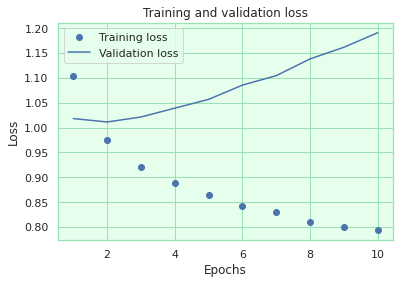

In [93]:
dense_model = initiate_model(summary=False)
fit_test_plot(dense_model, "dense_tf_idf", 10, train, val, test)

In [94]:
# Third model: GloVe embeddings + CNN (output mode should be int)
# Since most of the review word counts are capped at 100-120, we
# will set output seq. length to 110
txt_vec, train, val, test = vectorize_datasets(max_tokens, "int", output_sequence_length=110)

In [ ]:
# Donwloading GloVe-embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

In [95]:
path_to_glove_file = "glove.6B.100d.txt"  # includes 100-dim embeddings

# Mapping words to their respective embeddings
embeddings_index = {}
with open(path_to_glove_file) as f:
  for line in f:
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs, "f", sep=" ")
    embeddings_index[word] = coefs

embedding_dim = 100 
  
vocabulary = txt_vec.get_vocabulary()             
word_index = dict(zip(vocabulary, range(len(vocabulary))))   

# Initiating embedding matrix of size vocabulary x embed_dim
embedding_matrix = np.zeros((max_tokens, embedding_dim))    
 
# If there is an embedding for a word in our vocab., add it
# to the matrix
for word, i in word_index.items():
  if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:                         
        embedding_matrix[i] = embedding_vector

# Freezing the layer so that embeddings don't get changed
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

In [111]:
# A simple CNN with 1D convolutions, max. pooling layers and classifier at the end
int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation="softmax")(x)
cnn_glove_model = keras.Model(int_sequences_input, outputs)
cnn_glove_model.compile(optimizer="rmsprop",
                loss="categorical_crossentropy",
                metrics=["accuracy"])
cnn_glove_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         2000000   
                                                                 
 conv1d_10 (Conv1D)          (None, None, 128)         64128     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, None, 128)        0         
 1D)                                                             
                                                                 
 conv1d_11 (Conv1D)          (None, None, 128)         82048     
                                                                 
 global_max_pooling1d_4 (Glo  (None, 128)              0         
 balMaxPooling1D)                                          

Epoch 1/10
1540/1540 [==============================] - 52s 34ms/step - loss: 1.1602 - accuracy: 0.5628 - val_loss: 1.0697 - val_accuracy: 0.5905
Epoch 2/10
1540/1540 [==============================] - 74s 48ms/step - loss: 1.0642 - accuracy: 0.5969 - val_loss: 1.0612 - val_accuracy: 0.5973
Epoch 3/10
1540/1540 [==============================] - 50s 33ms/step - loss: 1.0284 - accuracy: 0.6091 - val_loss: 1.1405 - val_accuracy: 0.5939
Epoch 4/10
1540/1540 [==============================] - 53s 34ms/step - loss: 0.9997 - accuracy: 0.6191 - val_loss: 1.1251 - val_accuracy: 0.6004
Epoch 5/10
1540/1540 [==============================] - 52s 33ms/step - loss: 0.9799 - accuracy: 0.6242 - val_loss: 1.2545 - val_accuracy: 0.5969
Epoch 6/10
1540/1540 [==============================] - 50s 33ms/step - loss: 0.9602 - accuracy: 0.6300 - val_loss: 1.2288 - val_accuracy: 0.6020
Epoch 7/10
1540/1540 [==============================] - 53s 34ms/step - loss: 0.9470 - accuracy: 0.6345 - val_loss: 1.2612 -

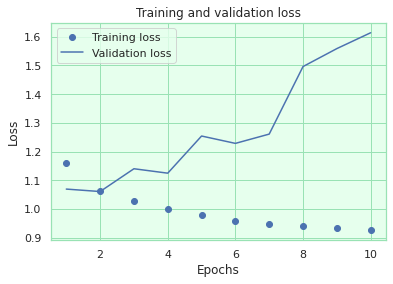

In [112]:
fit_test_plot(cnn_glove_model, "cnn_glove", 10, train, val, test)

In [113]:
# Final model: GloVe embeddings + Bidirectional LSTM
int_sequences_input = keras.Input(shape=(None,), dtype="int64")    
embedded = embedding_layer(int_sequences_input)     
x = layers.Bidirectional(layers.LSTM(16))(embedded)   
x = layers.Dropout(0.25)(x) 
outputs = layers.Dense(5, activation="softmax")(x)    
lstm_glove_model = keras.Model(int_sequences_input, outputs)
lstm_glove_model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
lstm_glove_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         2000000   
                                                                 
 bidirectional (Bidirectiona  (None, 32)               14976     
 l)                                                              
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_14 (Dense)            (None, 5)                 165       
                                                                 
Total params: 2,015,141
Trainable params: 15,141
Non-trainable params: 2,000,000
____________________________________________

Epoch 1/10
1540/1540 [==============================] - 155s 95ms/step - loss: 0.3835 - accuracy: 0.5580 - val_loss: 0.3572 - val_accuracy: 0.5806
Epoch 2/10
1540/1540 [==============================] - 146s 95ms/step - loss: 0.3486 - accuracy: 0.5979 - val_loss: 0.3418 - val_accuracy: 0.5998
Epoch 3/10
1540/1540 [==============================] - 143s 93ms/step - loss: 0.3385 - accuracy: 0.6078 - val_loss: 0.3451 - val_accuracy: 0.5983
Epoch 4/10
1540/1540 [==============================] - 146s 95ms/step - loss: 0.3329 - accuracy: 0.6132 - val_loss: 0.3378 - val_accuracy: 0.6071
Epoch 5/10
1540/1540 [==============================] - 146s 95ms/step - loss: 0.3288 - accuracy: 0.6195 - val_loss: 0.3353 - val_accuracy: 0.6069
Epoch 6/10
1540/1540 [==============================] - 144s 94ms/step - loss: 0.3261 - accuracy: 0.6219 - val_loss: 0.3376 - val_accuracy: 0.6092
Epoch 7/10
1540/1540 [==============================] - 144s 93ms/step - loss: 0.3230 - accuracy: 0.6255 - val_loss: 0

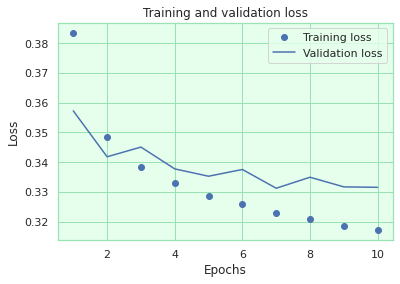

In [115]:
fit_test_plot(lstm_glove_model, "lstm_glove", 10, train, val, test)

At this point it seems pretty clear, that classifying this dataset into reviews with 5 ratings probably won't exceed accuracy of ~63% (although bidirecctional lstm shows promising results, and the curve shows that it is not yet overfitting). What's more, this accuracy is achieved with the simplest model of all: a dense model with 1 hidden layer, consisting of 32 hidden units, dropout layer with 25% dropout rate, trained on one-hot vectors. 

The next step is to try and do the same that has been done above (mostly modelling), but with 3 classes (positive, neutral, negative) instead of 5. This will make the problem easier, more general and easier to understand.

In [96]:
def merge_ratings(rating):
  if rating > 3:
    return 2  # good
  elif rating == 3:
    return 1  # neutral
  else:
    return 0  # bad

spotify_reviews_df['Rating'] = spotify_reviews_df['Rating'].apply(merge_ratings)

In [97]:
spotify_reviews_df.head(10)

,Review,Rating,Total_thumbsup,word_count
0,great music service the audio is high quality and the app is easy to use also very quick and friendly support,2,2,21
1,please ignore previous negative rating this app is super great i give it five stars,2,1,15
2,this popup get the best spotify experience on android 12 is too annoying please lets get rid of this,2,0,19
3,really buggy and terrible to use as of recently,0,1,9
4,dear spotify why do i get songs that i didnt put on my playlist and why do we have shuffle play,0,1,21
5,the player controls sometimes disappear for no reason app restart forgets what i was playing but fixes the issue,1,7,19
6,i love the selection and the lyrics are provided with the song youre listening to,2,0,15
7,still extremely slow when changing storage to external sd card im convinced this is done on purpose spotify knows of this issue and has done nothing to solve it over time i have changed sd cards each being faster in read write speedsall samsung brand and please add dont like song so it will never appear again in my searches or playlists,1,16,62
8,its a great app and the best mp3 music app i have ever used but there is one problem that why cant we play some songs or find some songs despite this the app is wonderful i recommend it its just the best,2,0,43
9,im deleting this app for the following reasons this app now has a failing business model whether streaming services like it or not the consumer doesnt want to pay for music they cant fully own and 6 ads successively upon logging in before a single song is too much closed the app during ad number 6 and im more patient than most if those are the only ways you can profit youve already peaked all thats left is your decline,0,318,80


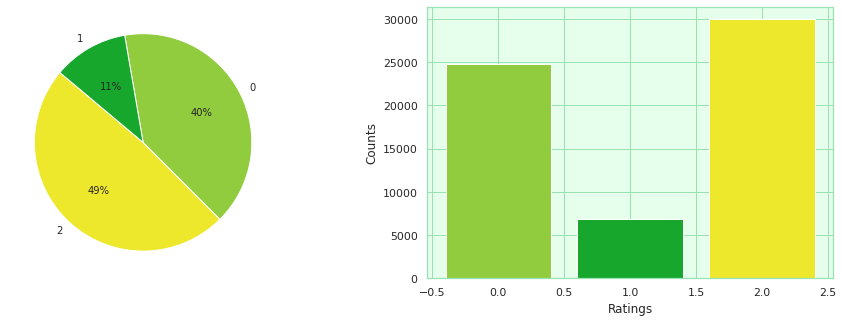

In [98]:
custom_colors = ['#eee82c', '#91cb3e', '#17A72D', '#4c934c', '#368245']
sns.set(rc={"grid.color":"#99e2b4", "axes.edgecolor":"#99e2b4", 
            "axes.facecolor":"#e6ffed"})

ratings_counts = spotify_reviews_df["Rating"].value_counts().to_dict()

labels, counts = zip(*ratings_counts.items())

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.pie(counts, labels = labels, textprops={'fontsize': 10}, startangle=140, 
       autopct='%1.0f%%', colors=custom_colors)

plt.subplot(1, 2, 2)
plt.bar(labels, counts, color=custom_colors)
plt.xlabel("Ratings")
plt.ylabel("Counts")

plt.show()

In [99]:
# Repeating the procedure done above
texts =  spotify_reviews_df["Review"].tolist()
labels = spotify_reviews_df["Rating"].tolist()

pairs = list(zip(texts, labels))
random.shuffle(pairs)
texts, labels = zip(*pairs)
texts, labels = list(texts), list(labels)

In [100]:
# Random baseline classifier
labels_copy = copy.copy(labels)
np.random.shuffle(labels_copy)
hits_array = np.array(labels) == np.array(labels_copy)
print(f"Accuracy of a random baseline classifier: {hits_array.mean()}")

Accuracy of a random baseline classifier: 0.40987758547910513


In [101]:
# Splitting data following 80/10/10 split
num_val_samples = int(0.10 * len(texts))
num_train_samples = len(texts) - 2 * num_val_samples

train_inputs =  texts[:num_train_samples]
train_targets = labels[:num_train_samples]

val_inputs = texts[num_train_samples:num_train_samples + num_val_samples]
val_targets = labels[num_train_samples:num_train_samples + num_val_samples]

test_inputs = texts[num_train_samples + num_val_samples:]
test_targets = labels[num_train_samples + num_val_samples:]

In [102]:
batch_size = 32

def make_dataset(inputs, targets):
  targets = to_categorical(targets, num_classes=3)  # one-hot encoding
  dataset = tf.data.Dataset.from_tensor_slices((inputs, targets))
  dataset = dataset.batch(batch_size)

  return dataset

train_ds = make_dataset(train_inputs, train_targets)
val_ds = make_dataset(val_inputs, val_targets)
test_ds = make_dataset(test_inputs, test_targets)

In [103]:
for inputs, targets in train_ds:
  print("inputs.shape:", inputs.shape)
  print("inputs.dtype:", inputs.dtype)
  print("targets.shape:", targets.shape)
  print("inputs[0]:", inputs[0])
  print("targets[0]:", targets[0])
  break

inputs.shape: (32,)
inputs.dtype: <dtype: 'string'>
targets.shape: (32, 3)
inputs[0]: tf.Tensor(b'very annyoing thing is when add comes i just can not understand that why they force us to freeking bye the premeum', shape=(), dtype=string)
targets[0]: tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)


In [104]:
# Repeating the same - first model will be a dense model, where each reviews
# is a multi_hot vector of unigrams and bigrams
max_tokens = 20000
_, train, val, test = vectorize_datasets(max_tokens, "multi_hot", 2)

In [146]:
dense_model = initiate_model(output_units=3)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_15 (Dense)            (None, 16)                320016    
                                                                 
 dropout_8 (Dropout)         (None, 16)                0         
                                                                 
 dense_16 (Dense)            (None, 3)                 51        
                                                                 
Total params: 320,067
Trainable params: 320,067
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
1540/1540 [==============================] - 10s 7ms/step - loss: 0.5886 - accuracy: 0.7889 - val_loss: 0.5630 - val_accuracy: 0.7962
Epoch 2/10
1540/1540 [==============================] - 10s 6ms/step - loss: 0.5328 - accuracy: 0.8109 - val_loss: 0.5643 - val_accuracy: 0.7988
Epoch 3/10
1540/1540 [==============================] - 10s 6ms/step - loss: 0.5161 - accuracy: 0.8178 - val_loss: 0.5712 - val_accuracy: 0.7983
Epoch 4/10
1540/1540 [==============================] - 10s 7ms/step - loss: 0.5010 - accuracy: 0.8239 - val_loss: 0.5783 - val_accuracy: 0.7993
Epoch 5/10
1540/1540 [==============================] - 10s 6ms/step - loss: 0.4909 - accuracy: 0.8297 - val_loss: 0.5803 - val_accuracy: 0.7974
Epoch 6/10
1540/1540 [==============================] - 10s 6ms/step - loss: 0.4784 - accuracy: 0.8331 - val_loss: 0.5853 - val_accuracy: 0.7980
Epoch 7/10
1540/1540 [==============================] - 10s 7ms/step - loss: 0.4671 - accuracy: 0.8380 - val_loss: 0.5938 - val_ac

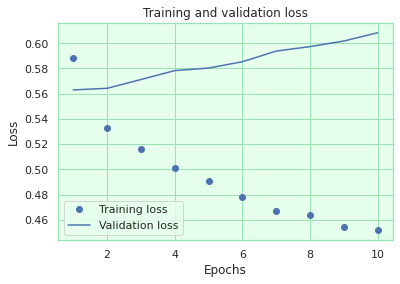

In [148]:
fit_test_plot(dense_model, "dense_one_hot_3_classes", 10, train, val, test)

In [105]:
# Second model: dense model, based on tf-idf vectors of unigrams and bigrams
_, train, val, test = vectorize_datasets(max_tokens, "tf_idf", 2)

Epoch 1/10
1540/1540 [==============================] - 13s 8ms/step - loss: 0.6453 - accuracy: 0.7722 - val_loss: 0.5825 - val_accuracy: 0.7918
Epoch 2/10
1540/1540 [==============================] - 10s 7ms/step - loss: 0.5505 - accuracy: 0.8051 - val_loss: 0.5770 - val_accuracy: 0.7959
Epoch 3/10
1540/1540 [==============================] - 10s 7ms/step - loss: 0.5192 - accuracy: 0.8170 - val_loss: 0.5870 - val_accuracy: 0.7977
Epoch 4/10
1540/1540 [==============================] - 11s 7ms/step - loss: 0.4923 - accuracy: 0.8258 - val_loss: 0.5937 - val_accuracy: 0.7931
Epoch 5/10
1540/1540 [==============================] - 10s 7ms/step - loss: 0.4791 - accuracy: 0.8308 - val_loss: 0.6050 - val_accuracy: 0.7922
Epoch 6/10
1540/1540 [==============================] - 12s 8ms/step - loss: 0.4645 - accuracy: 0.8364 - val_loss: 0.6182 - val_accuracy: 0.7927
Epoch 7/10
1540/1540 [==============================] - 10s 7ms/step - loss: 0.4532 - accuracy: 0.8429 - val_loss: 0.6272 - val_ac

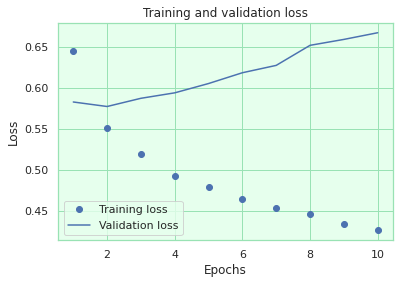

In [152]:
dense_model = initiate_model(output_units=3, summary=False)
fit_test_plot(dense_model, "dense_tf_idf_3_classes", 10, train, val, test)

The final model will be a bidirectional LSTM (we will jump over CNN). Another change would be to try and learn word embeddings from this directly. The reasoning is that it seems there are enough training examples to try and learn embeddings specific for this dataset. 

In [45]:
txt_vec, train, val, test = vectorize_datasets(max_tokens, "int", output_sequence_length=110)

In [42]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, 
                            output_dim=128, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
lstm_embeddings = keras.Model(inputs, outputs)
lstm_embeddings.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
lstm_embeddings.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 128)         2560000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 2,601,411
Trainable params: 2,601,411
Non-trainable params: 0
_________________________________________________

Epoch 1/10
1540/1540 [==============================] - 238s 135ms/step - loss: 0.5891 - accuracy: 0.7788 - val_loss: 0.5489 - val_accuracy: 0.7941
Epoch 2/10
1540/1540 [==============================] - 211s 137ms/step - loss: 0.5241 - accuracy: 0.8027 - val_loss: 0.5444 - val_accuracy: 0.7969
Epoch 3/10
1540/1540 [==============================] - 207s 135ms/step - loss: 0.5022 - accuracy: 0.8104 - val_loss: 0.5408 - val_accuracy: 0.8009
Epoch 4/10
1540/1540 [==============================] - 208s 135ms/step - loss: 0.4836 - accuracy: 0.8174 - val_loss: 0.5589 - val_accuracy: 0.7964
Epoch 5/10
1540/1540 [==============================] - 210s 136ms/step - loss: 0.4634 - accuracy: 0.8256 - val_loss: 0.5560 - val_accuracy: 0.7925
Epoch 6/10
1540/1540 [==============================] - 209s 135ms/step - loss: 0.4438 - accuracy: 0.8333 - val_loss: 0.5844 - val_accuracy: 0.7837
Epoch 7/10
1540/1540 [==============================] - 210s 136ms/step - loss: 0.4237 - accuracy: 0.8418 - val_

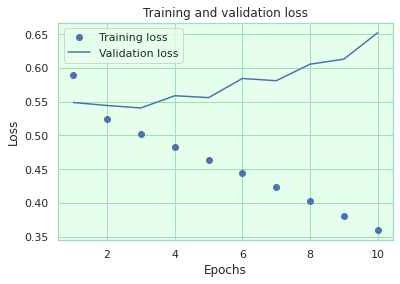

In [43]:
fit_test_plot(lstm_embeddings, "lstm_embeddings", 10, train, val, test)

In [50]:
# Building end-to-end model
model = keras.models.load_model('/content/lstm_embeddings.keras')
string_input = keras.Input(shape=(1,), dtype="string")
x = txt_vec(string_input)
preds = model(x)
end_to_end_model = keras.Model(string_input, preds)

In [51]:
ratings = {0 :"Bad", 1 :"Neutral", 2: "Good"}
probabilities = end_to_end_model.predict(
    [["this app seems to be pretty good"]])

ratings[np.argmax(probabilities[0])]

1/1 [==============================] - 3s 3s/step


'Good'

In [58]:
probabilities = end_to_end_model.predict(
    [["I hate this app"]])

ratings[np.argmax(probabilities[0])]

1/1 [==============================] - 0s 60ms/step


'Bad'